In [5]:
# ===============================
# 1. Importação de bibliotecas
# ===============================
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt


p_greedy = './src/outputs/greedy/'
p_reinforce = './src/outputs/reinforce/'

ps = [p_greedy, p_reinforce]
algs = ["Greedy", "Reinforce"]

# ===============================
# 2. Carregar os dados
# ===============================
candidates_path = "candidates.geojson"
selected_path   = "selected_sensors.geojson"
ranking_path    = "selection_ranking.csv"

candidates = []
selected = []
ranking = []

for p in ps:
    candidates.append(gpd.read_file(p + candidates_path))
    selected.append(gpd.read_file(p + selected_path))
    ranking.append(pd.read_csv(p + ranking_path))

    print("Arquivos carregados com sucesso!", p)
    print("Candidatos:", candidates[-1].shape)
    print("Selecionados:", selected[-1].shape)
    print("Ranking:", ranking[-1].shape)


Arquivos carregados com sucesso! ./src/outputs/greedy/
Candidatos: (370, 4)
Selecionados: (100, 5)
Ranking: (100, 3)
Arquivos carregados com sucesso! ./src/outputs/reinforce/
Candidatos: (370, 4)
Selecionados: (100, 5)
Ranking: (100, 3)


In [6]:
# ===============================
# 4. Estatísticas comparativas
# ===============================
for i, alg in enumerate(algs):
    print(f"\n===== {alg} =====")
    print("Número de candidatos:", len(candidates[i]))
    print("Número de selecionados:", len(selected[i]))
    print("Proporção selecionados/candidatos:", len(selected[i]) / len(candidates[i]))
    print("Ganho marginal - estatísticas:")
    print(ranking[i]["marginal_gain"].describe())



===== Greedy =====
Número de candidatos: 370
Número de selecionados: 100
Proporção selecionados/candidatos: 0.2702702702702703
Ganho marginal - estatísticas:
count    100.000000
mean       8.160000
std        2.241572
min        4.000000
25%        6.750000
50%        8.000000
75%        9.000000
max       15.000000
Name: marginal_gain, dtype: float64

===== Reinforce =====
Número de candidatos: 370
Número de selecionados: 100
Proporção selecionados/candidatos: 0.2702702702702703
Ganho marginal - estatísticas:
count    100.000000
mean       8.180000
std        2.231003
min        4.000000
25%        7.000000
50%        8.000000
75%        9.000000
max       15.000000
Name: marginal_gain, dtype: float64


In [7]:
# Diferenças entre os dois rankings
diff = ranking[0].compare(ranking[1])
print(diff.head())

  cand_id         marginal_gain      
     self   other          self other
1  c00180  c00029          11.0  15.0
3  c00029  c00180          15.0  11.0
4  c00334  c00034          10.0  14.0
6  c00034  c00334          14.0  10.0
7  c00267  c00000          11.0  13.0


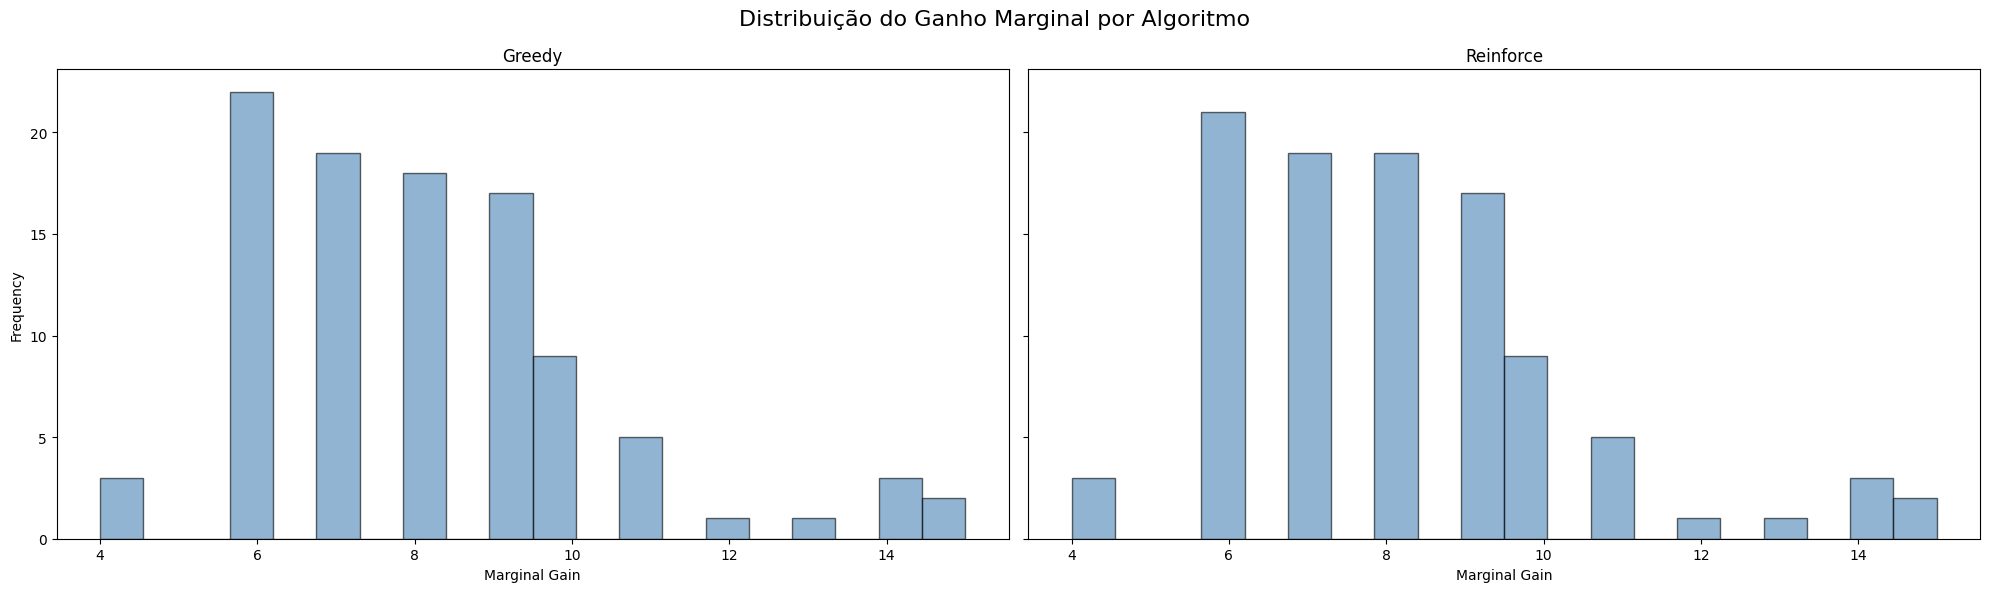

In [8]:
fig, axes = plt.subplots(1, len(algs), figsize=(20,6), sharey=True)

for i, alg in enumerate(algs):
    axes[i].hist(ranking[i]["marginal_gain"], bins=20, alpha=0.6, edgecolor="black", color="steelblue")
    axes[i].set_title(f"{alg}")
    axes[i].set_xlabel("Marginal Gain")
    if i == 0:
        axes[i].set_ylabel("Frequency")

plt.suptitle("Distribuição do Ganho Marginal por Algoritmo", fontsize=16)
plt.tight_layout()
plt.show()


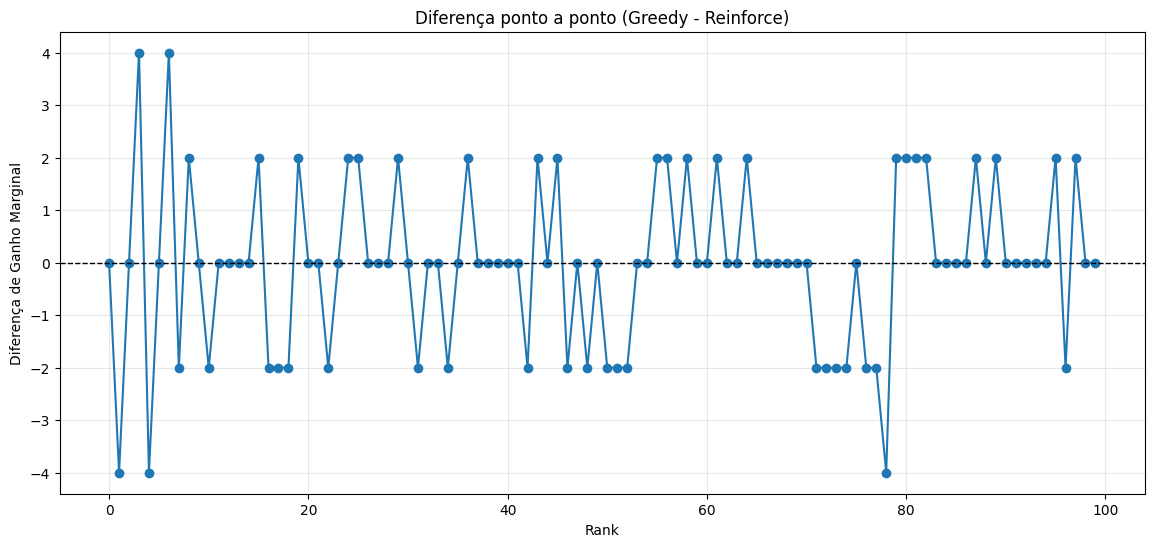

In [9]:
# ===============================
# 5b. Diferença ponto a ponto (Greedy - Reinforce)
# ===============================
plt.figure(figsize=(14,6))


diff = ranking[0]["marginal_gain"].values[:min(len(ranking[0]), len(ranking[1]))] - \
       ranking[1]["marginal_gain"].values[:min(len(ranking[0]), len(ranking[1]))]

plt.plot(diff, marker="o")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Rank")
plt.ylabel("Diferença de Ganho Marginal")
plt.title("Diferença ponto a ponto (Greedy - Reinforce)")
plt.grid(alpha=0.3)
plt.show()


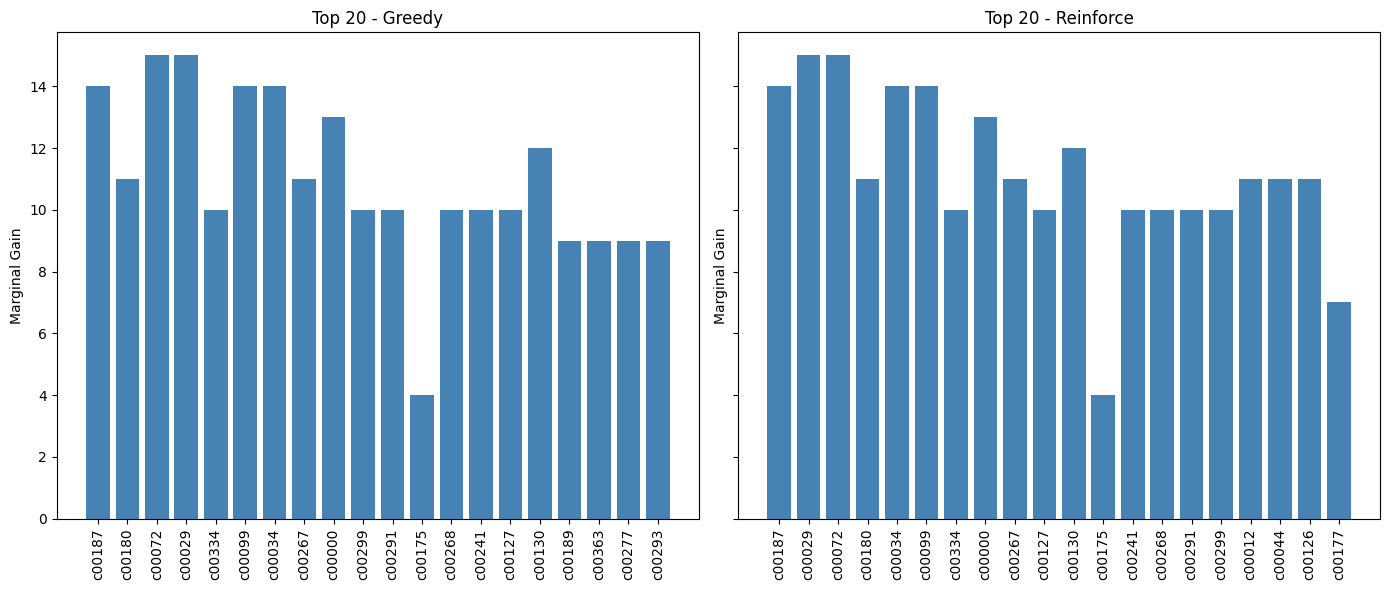

In [10]:
# ===============================
# 6. Top 20 candidatos de cada algoritmo
# ===============================
fig, axes = plt.subplots(1, len(algs), figsize=(14,6), sharey=True)

for i, alg in enumerate(algs):
    top20 = ranking[i].head(20)
    axes[i].bar(top20["cand_id"], top20["marginal_gain"], color="steelblue")
    axes[i].set_title(f"Top 20 - {alg}")
    axes[i].tick_params(axis="x", rotation=90)
    axes[i].set_ylabel("Marginal Gain")

plt.tight_layout()
plt.show()


In [12]:
# ===============================
# 7. Mapa interativo comparando algoritmos (com sobreposição)
# ===============================
center = [candidates[0].geometry.y.mean(), candidates[0].geometry.x.mean()]
m = folium.Map(location=center, zoom_start=12)

# ---- Todos os candidatos (azul) ----
for _, row in candidates[0].iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color="blue",
        fill=True,
        fill_opacity=0.4,
        popup=f"Candidato: {row['cand_id']}<br>Fonte: {row['source']}"
    ).add_to(m)

# ---- Preparar sets de selecionados ----
sel_greedy = set(selected[0]["cand_id"])
sel_reinf  = set(selected[1]["cand_id"])
sel_both   = sel_greedy & sel_reinf

# ---- Selecionados Greedy (vermelho) ----
for _, row in selected[0].iterrows():
    if row["cand_id"] not in sel_both:   # só greedy
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=6,
            color="red",
            fill=True,
            fill_opacity=0.8,
            popup=f"Greedy selecionou: {row['cand_id']}"
        ).add_to(m)

# ---- Selecionados Reinforce (verde) ----
for _, row in selected[1].iterrows():
    if row["cand_id"] not in sel_both:   # só reinforce
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=6,
            color="green",
            fill=True,
            fill_opacity=0.8,
            popup=f"Reinforce selecionou: {row['cand_id']}"
        ).add_to(m)

# ---- Selecionados por ambos (roxo) ----
for _, row in candidates[0][candidates[0]["cand_id"].isin(sel_both)].iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=8,
        color="purple",
        fill=True,
        fill_opacity=0.9,
        popup=f"Ambos selecionaram: {row['cand_id']}"
    ).add_to(m)

m


In [13]:
# Identificar interseção
sel_greedy = set(selected[0]["cand_id"])
sel_reinf  = set(selected[1]["cand_id"])
sel_both   = sel_greedy & sel_reinf

# Depois no loop:
# - vermelho = só greedy
# - verde = só reinforce
# - roxo = ambos


In [ ]:
# ===============================
# 9. Exportar versão do mapa
# ===============================
m.save("./docs/sensor_comparison_map.html")
print("Mapa salvo em sensor_comparison_map.html")


Mapa salvo em sensor_comparison_map.html
